
# Character-level Transformer on Tiny Shakespeare

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.sandbox.google.com/github/google-deepmind/optax/blob/main/examples/nanolm.ipynb)

This example demonstrates how to train a small-scale transformer-based language model (inspired by NanoGPT) on the Tiny Shakespeare dataset.  The core idea is to train a model that can predict the next character in a sequence of text based on the characters that came before it.

**Why the Tiny Shakespeare Dataset?**

* **Manageable Size:**  Since we're building a small-scale model, the Tiny Shakespeare dataset provides a suitable training corpus without overwhelming computational resources.
* **Linguistic Complexity:** Shakespeare's works offer a rich vocabulary and interesting grammatical patterns, making the dataset a good testbed for our model's language learning abilities.
* **Accessibility:** Easily accessible through [TensorFlow Datasets](https://www.tensorflow.org/datasets).

**Libraries Used**

* **JAX:** Provides the foundation for numerical computations and automatic differentiation.
* **Tensorflow Datasets (`tfds`)** Offers easy access to the Tiny Shakespeare dataset.
* **Flax's Linen Module:** Provides building blocks for defining our neural network architecture.
* **Optax:** Contains a library of optimization algorithms for training the model's parameters. In this example we'll use the {py:func}`optax.adamw` solver.

In [ ]:
import functools

import flax.linen as nn
import jax
import jax.numpy as jnp
from matplotlib import pyplot as plt
import optax
import tensorflow_datasets as tfds

# platform check
print("JAX running on", jax.devices()[0].platform.upper())

JAX running on GPU


# Hyperparameters and dataset download

Next, we set some important hyperparameters. This includes hyperparameters for the training process such as the learning rate `LEARNING_RATE` and the batch size `BATCH_SIZE`, as well as model parameters such as the context window size `BLOCK_SIZE` and the number of layers `NUM_LAYERS`.


After setting these, we load the Tiny Shakespeare dataset and print the length of the training set, which is around one million characters, and that of the validation set (around 50k characters). Finally, we print a small snippet of the train set.

In [ ]:
# @markdown Random seed:
SEED = 42  # @param{type:"integer"}
# @markdown Learning rate passed to the optimizer:
LEARNING_RATE = 5e-3 # @param{type:"number"}
# @markdown Batch size:
BATCH_SIZE = 128  # @param{type:"integer"}
# @markdown Number of training iterations:
N_ITERATIONS = 50_000  # @param{type:"integer"}
# @markdown Number of training iterations between two consecutive evaluations:
N_FREQ_EVAL = 2_000 # @param{type:"integer"}
# @markdown Rate for dropout in the transformer model
DROPOUT_RATE = 0.2  # @param{type:"number"}
# @markdown Context window for the transformer model
BLOCK_SIZE = 64  # @param{type:"integer"}
# @markdown Number of layer for the transformer model
NUM_LAYERS = 6  # @param{type:"integer"}
# @markdown Size of the embedding for the transformer model
EMBED_SIZE = 256  # @param{type:"integer"}
# @markdown Number of heads for the transformer model
NUM_HEADS = 8  # @param{type:"integer"}
# @markdown Size of the heads for the transformer model
HEAD_SIZE = 32  # @param{type:"integer"}


In [ ]:
ds = tfds.load("tiny_shakespeare")

# combine train and test examples into a single string
text_train = ""
for example in ds["train"].concatenate(ds["test"]).as_numpy_iterator():
  text_train += example["text"].decode("utf-8")

# similarly, create a single string for validation
text_validation = ""
for example in ds["validation"].as_numpy_iterator():
  text_validation += example["text"].decode("utf-8")

In [ ]:
print(f"Length of text for training: {len(text_train):_} characters")
print(f"Length of text for validation: {len(text_validation):_} characters")

Length of text for training: 1_059_624 characters
Length of text for validation: 55_770 characters


In [ ]:
# small sample of the train set
print(text_train[:1000])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



# Data preparation

To prepare the data for the model, we first create a vocabulary consisting of all the unique characters in the dataset. We print that vocabulary and its size.

We then define encoding and decoding functions to convert text into sequences of integers (representing our characters) and vice versa.

Finally, we define a function `get_batch` that returns random mini-batches of data. This function uses JAX's {py:func}`jax.lax.dynamic_slice` function to efficiently handle sequences of varying lengths within batches. The `@jax.jit` decorator compiles this function for faster execution. The function randomly samples a batch from the data and prepares input sequences (`x`) and target sequences (`y`). The target sequence is simply the input sequence shifted by one position, as the goal of the language model is to predict the next character given the previous ones.


In [ ]:
vocab = sorted(list(set(text_train)))
print("Vocabulary:, ", "".join(vocab))
print("Length of vocabulary: ", len(vocab))

Vocabulary:,  
 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
Length of vocabulary:  65


In [ ]:
# create a mapping from characters to integers
stoi = {ch: i for i, ch in enumerate(vocab)}
itos = {i: ch for i, ch in enumerate(vocab)}
encode = lambda s: [
    stoi[c] for c in s
]  # encoder: take a string, output a list of integers
decode = lambda l: "".join(
    [itos[i] for i in l]
)  # decoder: take a list of integers, output a string

# encode train and validation data
train_data = jnp.array(encode(text_train))
eval_data = jnp.array(encode(text_validation))

In [ ]:
dynamic_slice_vmap = jax.vmap(jax.lax.dynamic_slice, in_axes=(None, 0, None))


@jax.jit
def get_batch(random_key, data):
  """Prepares a random batch of training data.

  Args:
      random_key: A random seed for sampling a batch.
      data: The complete training dataset.

  Returns:
      x: Input sequences.
      y: Target sequences (shifted inputs).
  """
  ix = jax.random.randint(
      random_key, shape=(BATCH_SIZE, 1), minval=0, maxval=len(data) - BLOCK_SIZE
  )
  x = dynamic_slice_vmap(data, ix, (BLOCK_SIZE,))
  y = dynamic_slice_vmap(data, ix + 1, (BLOCK_SIZE,))
  return x, y

# NanoLM Model Definition

The NanoLM model itself is defined as a Flax Linen module.  The core of the model is a Transformer architecture, designed for sequence-to-sequence tasks like language modeling. Key parameters of the model, such as the number of layers, attention heads, and embedding size, are specified here.

Inside the model's `__call__` method, we first embed our input characters into vector representations. Positional embeddings are added to provide the model with a sense of order in the sequence. The core of the Transformer consists of multiple layers. Each layer has two main components:

 * **Multi-Head Attention**: This mechanism allows the model to "attend" to different parts of the input sequence, improving its understanding of context and relationships within the text. In the code this is implemented through the {py:class}`flax.linen.MultiHeadDotProductAttention` class.

 * **Feedforward Network**: This network processes the output of the attention layer, applying non-linear transformations to further learn complex patterns in the data. This is implemented through the {py:class}`flax.linen.Sequential` class.

Normalization and dropout (for regularization) are used within the layers to improve training stability.  Finally, a dense layer maps the model's output to the vocabulary size, producing probabilities for each character as the next potential character.

The generate function enables the model to create new text sequences. It iteratively generates one character at a time, conditioned on the previously generated text.


In [ ]:
class NanoLM(nn.Module):
  """NanoLM model."""
  vocab_size: int
  num_layers: int = 6
  num_heads: int = 8
  head_size: int = 32
  dropout_rate: float = 0.2
  embed_size: int = 256
  block_size: int = 64

  @nn.compact
  def __call__(self, x, training: bool):
    seq_len = x.shape[1]

    x = nn.Embed(self.vocab_size, self.embed_size)(x) + nn.Embed(
        self.block_size, self.embed_size
    )(jnp.arange(seq_len))
    for _ in range(self.num_layers):
      x_norm = nn.LayerNorm()(x)
      x = x + nn.MultiHeadDotProductAttention(
          num_heads=self.num_heads,
          qkv_features=self.head_size,
          out_features=self.head_size * self.num_heads,
          dropout_rate=self.dropout_rate,
      )(
          x_norm,
          x_norm,
          mask=jnp.tril(jnp.ones((x.shape[-2], x.shape[-2]))),
          deterministic=not training,
      )

      x = x + nn.Sequential([
          nn.Dense(4 * self.embed_size),
          nn.relu,
          nn.Dropout(self.dropout_rate, deterministic=not training),
          nn.Dense(self.embed_size),
      ])(nn.LayerNorm()(x))

    x = nn.LayerNorm()(x)
    return nn.Dense(self.vocab_size)(x)

  @functools.partial(jax.jit, static_argnames=("self", "length"))
  def generate(self, rng, params, length):
    def _scan_generate(carry, _):
      random_key, context = carry
      logits = self.apply(params, context, training=False)
      rng, rng_subkey = jax.random.split(random_key)
      new_token = jax.random.categorical(
          rng_subkey, logits[:, -1, :], axis=-1, shape=(1, 1)
      )
      context = jnp.concatenate([context[:, 1:], new_token], axis=1)
      return (rng, context), new_token

    _, new_tokens = jax.lax.scan(
        _scan_generate,
        (rng, jnp.zeros((1, self.block_size), dtype=jnp.int32)),
        (),
        length=length,
    )
    return new_tokens

# State, Optimizer, and Loss Definition

This section initializes the model's parameters, defines the loss function used for language modeling, and sets up the training and evaluation processes.

In this case the loss function `loss_fun` is the cross-entropy. It uses dropout for regularization, introduced via the `rngs={"dropout": dropout_key}` argument. We also define a function for evaluating the model's performance on unseen data (`eval_step`).

In [ ]:
model = NanoLM(
    vocab_size=len(vocab),
    num_layers=NUM_LAYERS,
    num_heads=NUM_HEADS,
    head_size=HEAD_SIZE,
    dropout_rate=DROPOUT_RATE,
    embed_size=EMBED_SIZE,
    block_size=BLOCK_SIZE,
)

def loss_fun(params, x, y, dropout_key):
  logits = model.apply(params, x, training=True, rngs={"dropout": dropout_key})
  return optax.softmax_cross_entropy_with_integer_labels(
      logits=logits, labels=y
  ).mean()


@jax.jit
def eval_step(params, x, y):
  logits = model.apply(params, x, training=False)
  return optax.softmax_cross_entropy_with_integer_labels(
      logits=logits, labels=y
  ).mean()

In [ ]:
key = jax.random.PRNGKey(SEED)
key, subkey = jax.random.split(key)

var_params = model.init(
    key,
    jnp.ones((BATCH_SIZE, BLOCK_SIZE), dtype=jnp.int32),
    training=False,
)

We've now instantiated a NanoLM model with the following number of parameters

In [ ]:
n_params = sum(p.size for p in jax.tree.leaves(var_params))

print(f"Total number of parameters: {n_params:_}")

Total number of parameters: 3_408_513


# Model training

We start by creating an optimizer and instantiating its state. In this case we'll use {py:func}`optax.adamw` but it's possible to replace this with other optax optimizers.


We then proceeded to the training loop. For maximum efficiency we extracted the most computationally intensive tasks inside the `step` function and just-in-time compile this function using `@jax.jit`. This allows JAX to perform some optimizations in our code and generally achieve a much higher efficiency than without.

Inside the training loop, we call the aforementioned `step` functions, as well as computing accuracy on a validation set every `N_FREQ_EVAL` iterations.

In [ ]:
# To run with SGD instead of adam, replace `adam` with `sgd`
opt = optax.adamw(learning_rate=LEARNING_RATE)

opt_state = opt.init(var_params)

In [ ]:
%%time

all_train_losses = []
all_eval_losses = []

# we define one iteration of the optimizer and JIT this function
@jax.jit
def step(key, params, opt_state):
  key, subkey = jax.random.split(key)
  batch = get_batch(key, train_data)
  loss, grad = jax.value_and_grad(loss_fun)(params, *batch, subkey)
  updates, opt_state = opt.update(grad, opt_state, params)
  params = optax.apply_updates(params, updates)
  return params, key, opt_state, loss


for i in range(N_ITERATIONS):
  var_params, key, opt_state, loss = step(key, var_params, opt_state)
  all_train_losses.append(loss)

  # once every N_FREQ_EVAL we compute loss on the validation set
  if i % N_FREQ_EVAL == 0:
    key, subkey = jax.random.split(key)
    eval_loss = eval_step(var_params, *get_batch(subkey, eval_data))
    all_eval_losses.append(eval_loss)
    print(f"Step: {i}\t train loss: {loss}\t eval loss: {eval_loss}")

Step: 0	 train loss: 4.586461067199707	 eval loss: 6.037547588348389
Step: 2000	 train loss: 1.3876519203186035	 eval loss: 1.4252502918243408
Step: 4000	 train loss: 1.280821442604065	 eval loss: 1.4000993967056274
Step: 6000	 train loss: 1.1978516578674316	 eval loss: 1.4045076370239258
Step: 8000	 train loss: 1.177159070968628	 eval loss: 1.387284278869629
Step: 10000	 train loss: 1.1472305059432983	 eval loss: 1.423332929611206
Step: 12000	 train loss: 1.107376217842102	 eval loss: 1.4390857219696045
Step: 14000	 train loss: 1.096900224685669	 eval loss: 1.474606990814209
Step: 16000	 train loss: 1.0772775411605835	 eval loss: 1.4595460891723633
Step: 18000	 train loss: 1.050074577331543	 eval loss: 1.4540534019470215
Step: 20000	 train loss: 1.0540519952774048	 eval loss: 1.4794009923934937
Step: 22000	 train loss: 1.035787582397461	 eval loss: 1.5094046592712402
Step: 24000	 train loss: 1.0402700901031494	 eval loss: 1.5403311252593994
Step: 26000	 train loss: 1.0363699197769165	

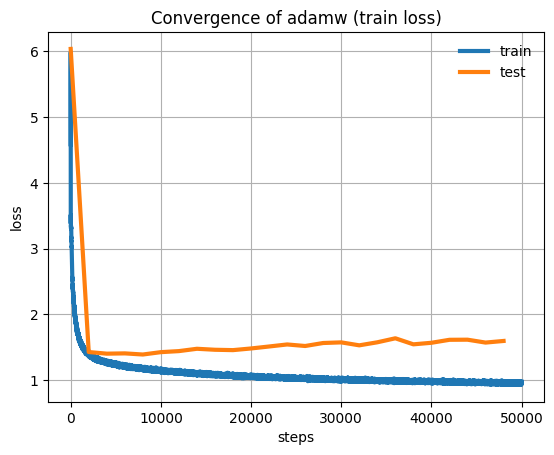

In [ ]:
plt.title("Convergence of adamw (train loss)")
plt.plot(all_train_losses, label="train", lw=3)
plt.plot(
    jnp.arange(0, len(all_eval_losses) * N_FREQ_EVAL, N_FREQ_EVAL),
    all_eval_losses,
    label="test",
    lw=3,
)
plt.xlabel("steps")
plt.ylabel("loss")
plt.grid()
plt.legend(frameon=False)
plt.show()

# Text generation

Finally, after training, we use the generate function to let the NanoGPT model demonstrate its ability to create text that resembles Shakespeare, albeit in a miniature form.

In [ ]:
# Let's now generate some text
key, subkey = jax.random.split(key)
text = model.generate(key, var_params, 1000)[:, 0, 0].tolist()
print(decode(text))

GREMIO:
So called, officer:
Peace, for me would be a mighty heart, and I'll do
any good.

MERCUTIO:
Ay, look'd dead made.

VALERIA:
Rather is in the present book of love
Than piece thy thoughts to shame, but yet book known
Where my Edward, whom I so could do it to him;
And see how the government of your blood,
Congeal'd your kingdom then we resign your highness;
Unless you scarcely know how I came, his wife;
And I may contain a little of England's heart
After a king of disdain! supect, tribunes,
The sun under thine is too large:
The senators do add to their trenches stretch'd,
With such as a toy, or be it known, I would
See my shame home, sweet friends, we are too dear:
Tell me consul, what's become the soldiers?

SOMERSET:
So fled; alas! much is possess'd by this means?
Away with the nightingale. He hast he wounded his sceptre
And hide his heir: go hence, to have his hearts
To close our bloods, for the climate to be
Ere one would be so often been seen, a greater stranger
Can have you 